# Adjust Jupyter settings

In [1]:
# widen cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:82% !important; }</style>"))

# display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [46]:
%%sh
python -m ipykernel install --user --name=mc9

Installed kernelspec mc9 in /home/mdawkins/.local/share/jupyter/kernels/mc9


# Imports

In [2]:
## Import packages
import gc
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shap
import sys
import time

from datetime import datetime
from functools import reduce

# print the JS visualization code to the notebook
shap.initjs()

# show all rows and columns of pandas dataframe
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 3600)

# show all numbers in pandas dataframes as 8dp floats
pd.options.display.float_format = '{:,.4f}'.format

# Primary constants

In [3]:
user = os.getenv('USERNAME')
shared_workspace = '/home/nikankarla/modelling_club_team9'
user_dir = os.path.join(shared_workspace, user)
raw_data_dir = os.path.join(shared_workspace, 'git_repos/mc2020_team9/data/raw')
modelling_dir = os.path.join(user_dir, '05_modelling')
modelling_scripts_dir = os.path.join(modelling_dir, 'scripts')
models_store_dir = os.path.join(modelling_dir, 'models')

application_train_filename = 'application_train.csv'
application_test_noTarget_filename = 'application_test_noTarget.csv'
bureau_balance_filename = 'bureau_balance.csv'
bureau_filename = 'bureau.csv'
credit_card_balance_filename = 'credit_card_balance.csv'
homecredit_columns_description_filename = 'HomeCredit_columns_description.csv'
installments_payments_filename = 'installments_payments.csv'
pos_cash_balance_filename = 'POS_CASH_balance.csv'
previous_application_filename = 'previous_application.csv'
sample_submission_filename = 'sample_submission.csv'

seed = 2021
response = 'TARGET'
primary_keys = ['SK_ID_CURR']
split = 'split'
non_feature_cols = primary_keys + [response] + [split]

# Quantium colours
qc1 = '#3F69AE'  # Blue
qc2 = '#Ef9C48'  # Orange
qc3 = '#44D5A3'  # Turquoise
qc4 = '#C96478'  # Burgundy
qc5 = '#EACB79'  # Yellow
qc6 = '#80DF7C'  # Green
qc7 = '#EF6348'  # Coral
qc8 = '#8F73BE'  # Violet
qcgrey = '#93908E'  # Grey
qcwgrey = '#BCB5AC'  # Warm Grey

# User-defined inputs

In [4]:
# Read in train and test data here
home_loan_train = pd.read_csv(os.path.join(raw_data_dir, application_train_filename))
home_loan_test = pd.read_csv(os.path.join(raw_data_dir, application_test_noTarget_filename))
home_loan_test['TARGET'] = None # Placeholder, target of test data should already be set to None in the data preparation step

# Helper functions

## File system helper functions

In [5]:
def create_dir_if_not_available(dir_path):
    if not os.path.exists(dir_path):
        print(f'Created directory: {dir_path}')
        os.makedirs(dir_path)
    else:
        print(f'Directory already exists: {dir_path}')



def save_json(dictionary, file_name_including_file_path_and_file_type):
    
    create_dir_if_not_available(os.path.dirname(os.path.realpath(file_name_including_file_path_and_file_type)))
    
    with open(file_name_including_file_path_and_file_type, "w") as save_file:
        json.dump(dictionary, save_file, indent=4)

## Plot PvO

In [6]:
def plot_pvo(
        data,
        title="PvO: overall",
        percentile_col='ntile',
        actual_col='response',
        pred_col='predictions',
        log_scale=False
):
    data = data.sort_values(percentile_col, ascending=True)
    fig = plt.figure(figsize=(12, 8))
    plt.clf()

    percentile = data[percentile_col]
    avg_predicted = data[pred_col]
    avg_actual = data[actual_col]

    # Main PvO
    plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.plot(percentile, avg_predicted, c=qc3, lw=3, label="Predicted")
    plt.plot(percentile, avg_actual, c=qc2, lw=3, label="Observed")
    plt.legend(loc="upper left")
    plt.ylabel("Average Score")
    plt.grid(True)
    plt.title(title)
    if log_scale:
        plt.yscale("log")
        deltadiff = np.log(avg_predicted / avg_actual)
    else:
        deltadiff = avg_predicted - avg_actual

    # Delta
    plt.subplot2grid((3, 1), (2, 0))
    plt.plot(percentile, deltadiff, c=qc1, lw=3)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.xlabel("Percentile")
    plt.ylabel("Pred/Obs (log)")
    plt.ylim(top=0.15, bottom=-0.15)
    plt.grid(True)
    plt.tight_layout()

    return fig

## Plot gains curve

In [9]:
#### Adapted from scikitplot.helpers.cumulative_gain_curve and scikitplot.metrics.plot_cumulative_gain

def cumulative_gain_curve(y_true, y_score, pos_label=None):
    
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    y_true, y_score = np.asarray(y_true), np.asarray(y_score) # not sure why they do this again, but leaving it here as I'm not sure whether removing it will break something

    # ensure binary classification if pos_label is not specified
    classes = np.unique(y_true)
    if (pos_label is None and
        not (np.array_equal(classes, [0, 1]) or
             np.array_equal(classes, [-1, 1]) or
             np.array_equal(classes, [0]) or
             np.array_equal(classes, [-1]) or
             np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)
    
    percentages = np.arange(start=1, stop=len(y_true) + 1)
    percentages = percentages / float(len(y_true))
    percentages = np.insert(percentages, 0, [0])
    percentages = [p*100.0 for p in percentages]
    
    def calculate_gains(y_true, y_score, perfect_model=False):
        
        if perfect_model:
            sorted_indices = np.argsort(y_true)[::-1]
        else:
            sorted_indices = np.argsort(y_score)[::-1]
        
        y_true = y_true[sorted_indices]
        gains = np.cumsum(y_true)

        gains = gains / float(np.sum(y_true))
        gains = np.insert(gains, 0, [0])
        
        return gains
    
    gains = calculate_gains(y_true, y_score, perfect_model=False)
    gains_perfect = calculate_gains(y_true, y_score, perfect_model=True)
    
    return percentages, gains, gains_perfect


def plot_cumulative_gain_single(y_true, y_score, title='Cumulative Gains Curve',
                         ax=None, figsize=None, title_fontsize="large",
                         text_fontsize="medium"):

    # Compute Cumulative Gain Curves
    percentages, gains, gains_perfect = cumulative_gain_curve(y_true, y_score)
    
    percentages_rounded = [round(x, 2) for x in percentages]
    data = pd.DataFrame(np.array([percentages_rounded, gains, gains_perfect]).T, columns=['Percentile', 'Model Gains', 'Perfect Model Gains'])
    gains_data = (
        data[['Percentile', 'Model Gains', 'Perfect Model Gains']]
        .groupby(
            'Percentile',
            as_index=False
        )
        .mean()
    )

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    ax.plot([0, 100], [0, 1], 'k--', lw=2, label='Random Model')
    ax.plot(gains_data['Percentile'], gains_data['Model Gains'], lw=3, label='Model Gains', c=qc2)
    ax.plot(gains_data['Percentile'], gains_data['Perfect Model Gains'], lw=3, label='Perfect Model Gains', c=qc1)

    ax.set_xlim([0.0, 100.0])
    ax.set_ylim([0.0, 1.0])

    ax.set_xlabel('Percentile', fontsize=text_fontsize)
    ax.set_ylabel('Gain', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.grid('on')
    ax.legend(loc='best', fontsize=text_fontsize)

    return fig

def plot_cumulative_gain_multiple(dataset_observed_predictions_dict, title='Cumulative Gains Curves',
                                 ax=None, figsize=None, title_fontsize='large', text_fontsize='medium'):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.plot([0, 100], [0, 1], 'k--', lw=2, label='Random Model')
    ax.set_xlim([0.0, 100.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('Percentile', fontsize=text_fontsize)
    ax.set_ylabel('Gain', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.grid('on')
        
    model_gains_colours = iter([qc2, qc3, qc4, qc5])
    # Compute Cumulative Gain Curves for each set of observations and predictions
    for indx, (dataset, observed_and_predictions_dict) in enumerate(dataset_observed_predictions_dict.items()):
        
        percentages, gains, gains_perfect = cumulative_gain_curve(observed_and_predictions_dict[response], observed_and_predictions_dict['prediction'])
        ax.plot(percentages, gains, lw=3, label=f'[{dataset}] Model Gains', c=next(model_gains_colours, qc2))
        
        if indx == 0:
            percentages_rounded = [round(x, 2) for x in percentages]
            data = pd.DataFrame(np.array([percentages_rounded, gains]).T, columns=['Percentile', f'[{dataset}] Model Gains'])
            data_rounded = (
                data[['Percentile', f'[{dataset}] Model Gains']]
                .groupby(
                    'Percentile',
                    as_index=False
                )
                .mean()
            )
            gains_data = data_rounded
            
        elif indx == (len(dataset_observed_predictions_dict.keys()) - 1):
            percentages_rounded = [round(x, 2) for x in percentages]
            data = pd.DataFrame(np.array([percentages_rounded, gains, gains_perfect]).T, columns=['Percentile', f'[{dataset}] Model Gains', 'Perfect Model Gains'])
            data_rounded = (
                data[['Percentile', f'[{dataset}] Model Gains', 'Perfect Model Gains']]
                .groupby(
                    'Percentile',
                    as_index=False
                )
                .mean()
            )
            gains_data = pd.concat([gains_data, data_rounded[[f'[{dataset}] Model Gains', 'Perfect Model Gains']]], axis=1)
            
        else:
            percentages_rounded = [round(x, 2) for x in percentages]
            data = pd.DataFrame(np.array([percentages_rounded, gains]).T, columns=['Percentile', f'[{dataset}] Model Gains'])
            data_rounded = (
                data[['Percentile', f'[{dataset}] Model Gains']]
                .groupby(
                    'Percentile',
                    as_index=False
                )
                .mean()
            )
            gains_data = pd.concat([gains_data, data_rounded[f'[{dataset}] Model Gains']], axis=1)
    
    # Gains_perfect_should be the same regardless of split, given a sufficiently large sample size for each split
    # So no need to include in above for loop
    ax.plot(percentages, gains_perfect, lw=3, label='Perfect Model Gains', c=qc1) 
    ax.legend(loc='best', fontsize=text_fontsize)

    return gains_data, fig

## Calculate Gini

In [10]:
# train_observed_prediction = 
# train[['TARGET', 'prediction']]

def gini(observed, predicted):
    # observed and predicted must be numpy arrays    
    observed = np.asarray(observed)
    predicted = np.asarray(predicted)
    
    # check if the data shapes match
    assert observed.shape[0] == predicted.shape[0], 'Gini error: unequal number of rows between observed and prediction'
     
    # concatenate observed, predicted and index 0,1,2,...
    _all = np.asarray(
        np.c_[
            observed,
            predicted,
            np.arange(observed.shape[0])
        ]
        , dtype=np.float
    )
    # just set the values of the columns representing each values
    _observed = 0
    _PREDICTED = 1
    _INDEX = 2
    # sort by predicted descending, then by index ascending
    sort_order = np.lexsort((_all[:, _INDEX], -1 * _all[:, _PREDICTED]))
    _all = _all[sort_order]
    # compute sum of real values for normalisation issues
    total_losses = _all[:, _observed].sum()
    # using cumsum on sorted data to measure how 'unsorted' the prediction are ( very hard to read without normalisation)
    gini_sum = _all[:, _observed].cumsum().sum() / total_losses
    #centering it to zero
    gini_sum -= (observed.shape[0] + 1.0) / 2.0
    # general normalisation
    return gini_sum / observed.shape[0]
 
def gini_normalised(observed_and_prediction_data, col_obs='TARGET', col_pred='prediction'):
    
    observed, predicted = observed_and_prediction_data[col_obs].values, observed_and_prediction_data[col_pred].values

    ## normalised gini so that regardless of the data, same ordering returns a value of 1
    return gini(observed, predicted) / gini(observed, observed)

## Plot lift

In [11]:
def plot_lift(observed_and_prediction_data, col_obs='TARGET', col_pred='prediction', gini=True, return_data=False):
    
    if gini==True:
        title_gini = " (normalised gini=" + str(round(gini_normalised(observed_and_prediction_data, col_obs=col_obs, col_pred=col_pred),5)) + ")"
    else:
        title_gini = ""
        
    # Sort by predictions
    obs, pred = observed_and_prediction_data[col_obs].values, observed_and_prediction_data[col_pred].values
    sortidx = np.argsort(pred)[::-1]
    obs, pred = obs[sortidx], pred[sortidx]
    l = len(obs)
    
    # Average observed
    avg_o = obs.mean()
    
    # Percentiles
    perc = np.arange(1,101,1)
    lift = []
    cum_lift = []
    prev_n = 0
    for p in perc:
        
        n = int(l * (p/100.)) # how many values up to the pth percentile)
        cum_lift.append(obs[0:n].mean()/avg_o)
        
        lift.append(obs[prev_n:n].mean()/avg_o)
        prev_n = n
    
    
    perc = list(reversed(perc))
        
    # Cumulative lift
    fig = plt.figure(figsize=(12,6))
    plt.clf()
    plt.plot(perc, lift, c=qc3, lw=3, label="Model lift")
    plt.plot(perc, cum_lift, c=qc2, lw=3, label="Cumulative lift")
    ax = plt.gca()
    ax.set_xlim(100, 0)
    plt.legend(loc="best")
    plt.xlabel("Percentile")
    plt.ylabel("Lift")
    plt.title("Lift" + title_gini)
    plt.grid(True)
    plt.tight_layout()

    # Return
    if return_data:
        return fig, lift, cum_lift
    else:
        return fig

def plot_combined_lift(train_validation_lift_data, train_gini='', validation_gini=''):
    
    fig = plt.figure(figsize=(12,6))
    plt.clf()
    plt.plot(train_validation_lift_data['Percentile'], train_validation_lift_data['Train Lift'], c=qc2, lw=3, label="Training Lift")
    plt.plot(train_validation_lift_data['Percentile'], train_validation_lift_data['Validation Lift'], c=qc3, lw=3, label="Validation Lift")
    plt.plot(train_validation_lift_data['Percentile'], train_validation_lift_data['Train Cumulative Lift'], c=qc4, lw=3, label="Training Cumulative Lift")
    plt.plot(train_validation_lift_data['Percentile'], train_validation_lift_data['Validation Cumulative Lift'], c=qc5, lw=3, label="Validation Cumulative Lift")
    ax = plt.gca()
    ax.set_xlim(100, 0)
    plt.legend(loc="best")
    plt.xlabel("Percentile")
    plt.ylabel("Lift")
    plt.title("Lift" + os.linesep + 'Training Gini: ' + str(train_gini) + os.linesep + 'Validation Gini: ' + str(validation_gini))
    plt.grid(True)
    plt.tight_layout()
    
    return fig

# Transform model file into required inputs for training

In [12]:
## Merge train and test into one table
home_loan_train['split'] = np.random.choice(
    a=["train", "validation"],
    p=[0.95, 0.05],
    size=home_loan_train.shape[0]
)

home_loan_test['split'] = "test"

model_file = pd.concat(
    [
        home_loan_train,
        home_loan_test
    ],
    axis=0
)
model_file['TARGET'] = model_file['TARGET'].astype(float)

model_file

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,split
0,113072,0.0000,Revolving loans,M,Y,Y,0,"283,500.0000","180,000.0000","9,000.0000","180,000.0000",Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.0053,-20259,-9894,"-9,025.0000",-3639,10.0000,1,1,0,1,0,0,Laborers,2.0000,2,2,WEDNESDAY,15,0,0,0,0,0,0,Housing,0.3376,0.4454,0.5989,0.0928,0.1078,0.9796,nan,nan,0.0000,0.2069,0.1667,nan,0.0970,nan,0.0906,nan,0.0000,0.0945,0.1118,0.9796,nan,nan,0.0000,0.2069,0.1667,nan,0.0993,nan,0.0944,nan,0.0000,0.0937,0.1078,0.9796,nan,nan,0.0000,0.2069,0.1667,nan,0.0987,nan,0.0923,nan,0.0000,NaN,block of flats,0.0780,Panel,No,4.0000,0.0000,4.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,train
1,225465,0.0000,Cash loans,F,N,Y,0,"67,500.0000","182,016.0000","10,291.5000","144,000.0000",Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.0207,-24241,365243,"-12,328.0000",-4489,nan,1,0,0,1,0,0,NaN,2.0000,3,3,THURSDAY,6,0,0,0,0,0,0,XNA,nan,0.4355,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.0000,0.0000,0.0000,0.0000,"-1,014.0000",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,train
2,260656,0.0000,Cash loans,F,N,Y,0,"112,500.0000","315,000.0000","17,716.5000","315,000.0000",Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.0070,-19449,-12081,"-5,625.0000",-2912,nan,1,1,1,1,1,0,Medicine staff,2.0000,2,2,FRIDAY,16,0,0,0,0,0,0,Medicine,nan,0.5681,0.6642,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [13]:
# feature list
features = [col for col in model_file.columns if col not in non_feature_cols]

In [14]:
# convert categorical features to "category" type
columns_and_types = model_file.dtypes.to_dict()
categorical_features = [col for col, typ in columns_and_types.items() if (typ.name in ['object', 'category']) and col in features]
for col in categorical_features:
    model_file[col] = model_file[col].astype('category')


In [15]:
train = model_file.loc[model_file['split'] == "train"]
validation = model_file.loc[model_file['split'] == "validation"]
test = model_file.loc[model_file['split'] == "test"]

train.drop(columns=['split'], inplace=True)
validation.drop(columns=['split'], inplace=True)
test.drop(columns=['split'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
train_dataset = lgb.Dataset(
    data=train[features],
    label=train[response],
    feature_name=features, 
    categorical_feature=categorical_features
)
validation_dataset = lgb.Dataset(
    data=validation[features],
    label=validation[response],
    feature_name=features, 
    categorical_feature=categorical_features,
    reference=train_dataset
)

# Train model

In [17]:
EVAL_RESULTS = {}
params = {
    'objective': 'binary',  # binary = log loss objective function
    'metric': ['auc', 'binary_logloss', 'mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error'],
    'n_jobs': -1,
    'learning_rate': 0.1,
    "seed": seed
}

model = lgb.train(
    params=params,
    train_set=train_dataset,
    num_boost_round=2500,
    early_stopping_rounds=25,
    valid_sets=[train_dataset, validation_dataset],
    verbose_eval=1,
    evals_result=EVAL_RESULTS
)

Using categorical_feature in Dataset.


[LightGBM] [Info] Number of positive: 16546, number of negative: 188090
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11289
[LightGBM] [Info] Number of data points in the train set: 204636, number of used features: 115


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080856 -> initscore=-2.430776
[LightGBM] [Info] Start training from score -2.430776
[1]	training's auc: 0.714144	training's binary_logloss: 0.275307	training's l1: 0.147904	training's l2: 0.0734291	training's rmse: 0.270978	valid_1's auc: 0.72802	valid_1's binary_logloss: 0.275305	valid_1's l1: 0.147963	valid_1's l2: 0.0734807	valid_1's rmse: 0.271073
Training until validation scores don't improve for 25 rounds
[2]	training's auc: 0.722338	training's binary_logloss: 0.271345	training's l1: 0.147212	training's l2: 0.0727309	training's rmse: 0.269687	valid_1's auc: 0.736035	valid_1's binary_logloss: 0.271061	valid_1's l1: 0.147183	valid_1's l2: 0.0727346	valid_1's rmse: 0.269694
[3]	training's auc: 0.724711	training's binary_logloss: 0.268211	training's l1: 0.146546	training's l2: 0.0721499	training's rmse: 0.268607	valid_1's auc: 0.73748	valid_1's binary_logloss: 0.267755	valid_1's l1: 0.146487	valid_1's l2: 0.0721233	valid_1's rmse: 0.2

# Model results

## Secondary constants

In [19]:
timestamp_of_model = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

# model results directory (model, as well as parameters and feature list are saved here)
model_results_dir = os.path.join(models_store_dir, timestamp_of_model)
model_parameters_filename = os.path.join(model_results_dir, 'model_parameters.json')
model_features_filename = os.path.join(model_results_dir, 'model_features.json')
model_categorical_feature_levels_filename = os.path.join(model_results_dir, 'categorical_feature_levels.json')

# predictions directory
predictions_dir = os.path.join(model_results_dir, 'predictions')
predictions_train_filename = os.path.join(predictions_dir, 'predictions_train.csv')
predictions_validation_filename = os.path.join(predictions_dir, 'predictions_validation.csv')
predictions_test_filename = os.path.join(predictions_dir, 'predictions_test.csv')

# diagnostics directories
model_diagnostics_dir = os.path.join(model_results_dir, 'diagnostics')

## error curves
error_curves_dir = os.path.join(model_diagnostics_dir, 'error_curves')
error_curves_csv_filename = os.path.join(error_curves_dir, 'error_curves.csv')

## pvo
pvo_dir = os.path.join(model_diagnostics_dir, 'pvo')

## variable importance
variable_importance_dir = os.path.join(model_diagnostics_dir, 'variable_importance')
variable_importance_gain_csv_filename = os.path.join(variable_importance_dir, 'variable_importance_gain.csv')
variable_importance_split_csv_filename = os.path.join(variable_importance_dir, 'variable_importance_split.csv')

## oneways
oneways_dir = os.path.join(model_diagnostics_dir, 'oneways')

## pdp
pdp_dir = os.path.join(model_diagnostics_dir, 'pdp')

## shap
shap_dir = os.path.join(model_diagnostics_dir, 'shap')

## treeviz
treeviz_dir = os.path.join(model_diagnostics_dir, 'treeviz')

# ## other diagnostics
other_diagnostics_dir = os.path.join(model_diagnostics_dir, 'other_diagnostics')

# ROC Curve
roc_curve_dir = os.path.join(model_diagnostics_dir, 'roc_curve')

# Gains curve
gains_curve_dir = os.path.join(model_diagnostics_dir, 'gains_curve')
train_validation_gains_curve_csv_filename = os.path.join(gains_curve_dir, 'train_validation_gains_curves.csv')

# Gini
gini_dir = os.path.join(model_diagnostics_dir, 'gini')
gini_json_filename = os.path.join(gini_dir, 'gini_scores.json')

# Lift
lift_dir = os.path.join(model_diagnostics_dir, 'lift')
train_validation_lift_csv_filename = os.path.join(lift_dir, 'train_validation_lift.csv')

# MAPE
mape_dir = os.path.join(model_diagnostics_dir, 'MAPE')

# Split value histograms
split_value_histograms_dir = os.path.join(model_diagnostics_dir, 'split_value_histograms')


## Save model

In [20]:
model_name_gain_txt = 'model_' + timestamp_of_model + '_gain.txt'
model_name_split_txt = 'model_' + timestamp_of_model + '_split.txt'
model_name_gain_json = 'model_' + timestamp_of_model + '_gain.json'
model_name_split_json = 'model_' + timestamp_of_model + '_split.json'

create_dir_if_not_available(model_results_dir)

# Save model as .txt files
model.save_model(filename=os.path.join(model_results_dir, model_name_gain_txt), importance_type='gain')
model.save_model(filename=os.path.join(model_results_dir, model_name_split_txt), importance_type='split')

# Save model as .json files
model_gain_json = model.dump_model(importance_type='gain')
model_split_json = model.dump_model(importance_type='split')
save_json(model_gain_json, os.path.join(model_results_dir, model_name_gain_json))
save_json(model_split_json, os.path.join(model_results_dir, model_name_split_json))


Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012


Directory already exists: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012
Directory already exists: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012


## Save model parameters

In [21]:
# best iteration
model_best_iteration = model.best_iteration

# best score
model_best_score = {}
for key, value in model.best_score.items():
    dataset = key
    metrics_and_best_scores = value
    model_best_score[dataset] = list(metrics_and_best_scores.items())
    
# params
model_params = model.params

# num_trees
model_num_trees = model.num_trees()

# num_features
model_num_features = model.num_feature()


model_parameters_dict = {
    'best_iteration': model_best_iteration
    , 'best_score': model_best_score
    , 'model_params': model_params
    , 'num_trees': model_num_trees
    , 'num_features': model_num_features
}

save_json(model_parameters_dict, model_parameters_filename)

Directory already exists: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012


In [22]:
# feature list
model_features = model.feature_name()

model_features_dict = {
    'features': {k: v for k,v in enumerate(model_features)}
}

save_json(model_features_dict, model_features_filename)

Directory already exists: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012


In [23]:
# list of levels in each categorical feature
categorical_feature_indices = model.params['categorical_column']
categorical_levels = model.pandas_categorical

model_categorical_feature_levels = {
    'categorical_feature_levels': {
        model_features[categorical_feature_index]: {numeric_encoding: level for numeric_encoding, level in enumerate(categorical_levels[categorical_feature_number])} 
        for categorical_feature_number, categorical_feature_index in enumerate(categorical_feature_indices)
    }
}

save_json(model_categorical_feature_levels, model_categorical_feature_levels_filename)

Directory already exists: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012


## Save predictions

In [24]:
train['prediction'] = model.predict(train[features])
validation['prediction'] = model.predict(validation[features])
test['prediction'] = model.predict(test[features])

create_dir_if_not_available(predictions_dir)
predictions_dir

train[['SK_ID_CURR', 'prediction']].to_csv(path_or_buf=predictions_train_filename, header=True, index=False)
validation[['SK_ID_CURR', 'prediction']].to_csv(path_or_buf=predictions_validation_filename, header=True, index=False)
test[['SK_ID_CURR', 'prediction']].to_csv(path_or_buf=predictions_test_filename, header=True, index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/predictions



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/predictions'

## Save model results/diagnostics

In [25]:
diagnostics_dir_list = [
    model_diagnostics_dir
    , error_curves_dir
    , pvo_dir
    , variable_importance_dir
    , oneways_dir
    , pdp_dir
    , shap_dir
    , treeviz_dir
    , other_diagnostics_dir
    , roc_curve_dir
    , gains_curve_dir
    , gini_dir
    , lift_dir
    , mape_dir
    , split_value_histograms_dir 
]

for diagnostic_dir in diagnostics_dir_list:
    create_dir_if_not_available(diagnostic_dir)

Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/error_curves
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/pvo
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/variable_importance
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/oneways
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/pdp
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/shap
Created directory: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/treeviz
Created directory: /home/n

In [26]:
# LightGBM renames some metrics to aliases. This mapping converts aliases to more human-understandable labels, or leaves them as is if they are already understandable
metric_map = {
    'auc': 'auc'
    , 'binary_logloss': 'binary_logloss'
    , 'l1': 'mean_absolute_error'
    , 'mean_absolute_error': 'mean_absolute_error'
    , 'l2': 'mean_squared_error'
    , 'mean_squared_error': 'mean_squared_error'
    , 'rmse': 'root_mean_squared_error'
    , 'root_mean_squared_error': 'root_mean_squared_error'
}

### Error curves

'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/error_curves/error_curves.csv'

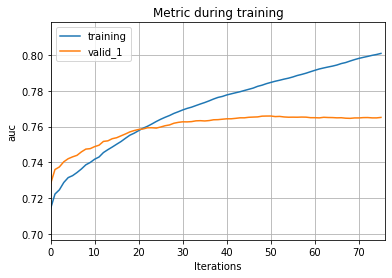

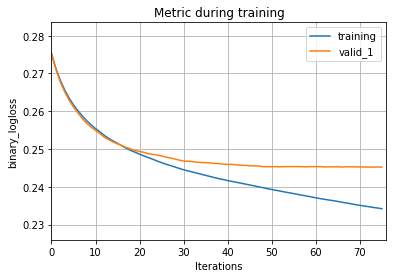

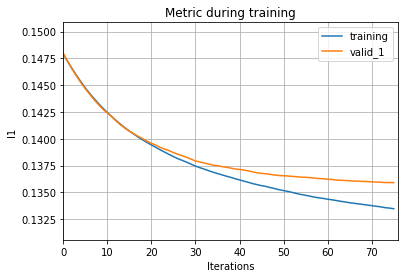

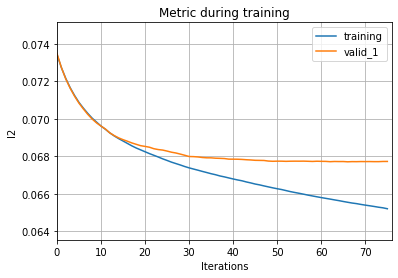

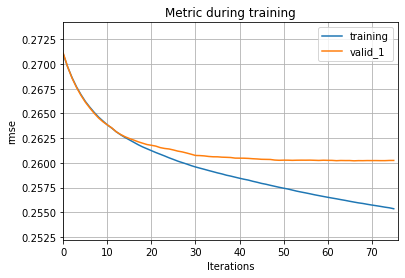

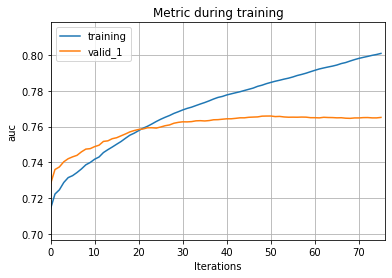

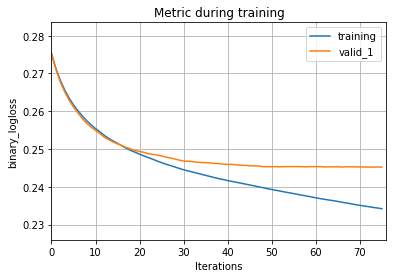

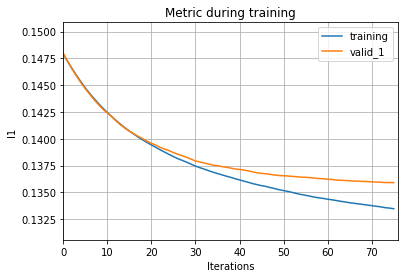

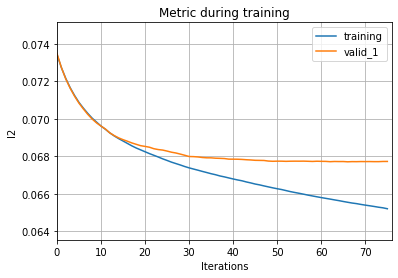

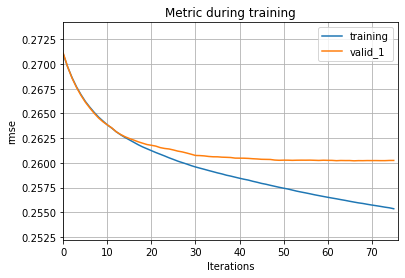

In [27]:
model_metrics = []
model_metrics_scores = []

for dataset, metrics_and_scores in EVAL_RESULTS.items():
    for metric, scores in metrics_and_scores.items():
        metric_readable = metric_map[metric]
        model_metrics.append(dataset + '_' + metric_readable)
        model_metrics_scores.append(scores)
        
        error_curve_plot = lgb.plot_metric(EVAL_RESULTS, metric=metric).get_figure()
        error_curve_plot.savefig(os.path.join(error_curves_dir, 'error_curve_' + metric_readable + '.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")

error_curves_data = pd.DataFrame(np.array(model_metrics_scores).T, columns=model_metrics)

error_curves_csv_filename
error_curves_data.to_csv(path_or_buf=error_curves_csv_filename, header=True, index=True, index_label='iteration')

### Variable importance

#### Csv

In [28]:
importance_col = 'importance_gain'

variable_importance_data_gain = pd.DataFrame(
    np.array(
        [
            model_features
            , model.feature_importance(importance_type='gain').tolist()
        ]
    ).T
    , columns=['feature', importance_col]
)

variable_importance_data_gain[importance_col] = variable_importance_data_gain[importance_col].astype(float)
variable_importance_data_gain.sort_values(by=importance_col, axis=0, ascending=False, inplace=True)
variable_importance_data_gain[importance_col+'_normalised'] = variable_importance_data_gain[importance_col] / variable_importance_data_gain.iloc[0][importance_col]

variable_importance_gain_csv_filename

variable_importance_data_gain
variable_importance_data_gain.to_csv(path_or_buf=variable_importance_gain_csv_filename, header=True, index=False)

'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/variable_importance/variable_importance_gain.csv'

,feature,importance_gain,importance_gain_normalised
41,EXT_SOURCE_3,"26,759.3152",1.0000
40,EXT_SOURCE_2,"21,580.8595",0.8065
39,EXT_SOURCE_1,"7,661.6896",0.2863
38,ORGANIZATION_TYPE,"6,700.1843",0.2504
6,AMT_CREDIT,"2,549.2215",0.0953
15,DAYS_BIRTH,"2,309.8451",0.0863
8,AMT_GOODS_PRICE,"2,216.9983",0.0828
16,DAYS_EMPLOYED,"1,987.1711",0.0743
7,AMT_ANNUITY,"1,856.2265",0.0694
26,OCCUPATION_TYPE,"1,765.1051",0.0660


In [29]:
importance_col = 'importance_split'

variable_importance_data_split = pd.DataFrame(
    np.array(
        [
            model_features
            , model.feature_importance(importance_type='split').tolist()
        ]
    ).T
    , columns=['feature', importance_col])

variable_importance_data_split[importance_col] = variable_importance_data_split[importance_col].astype(float)
variable_importance_data_split.sort_values(by=importance_col, axis=0, ascending=False, inplace=True)
variable_importance_data_split[importance_col+'_normalised'] = variable_importance_data_split[importance_col] / variable_importance_data_split.iloc[0][importance_col]

variable_importance_split_csv_filename

variable_importance_data_split
variable_importance_data_split.to_csv(path_or_buf=variable_importance_split_csv_filename, header=True, index=False)

'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/variable_importance/variable_importance_split.csv'

,feature,importance_split,importance_split_normalised
38,ORGANIZATION_TYPE,239.0000,1.0000
39,EXT_SOURCE_1,161.0000,0.6736
40,EXT_SOURCE_2,139.0000,0.5816
41,EXT_SOURCE_3,134.0000,0.5607
15,DAYS_BIRTH,72.0000,0.3013
6,AMT_CREDIT,69.0000,0.2887
7,AMT_ANNUITY,64.0000,0.2678
8,AMT_GOODS_PRICE,57.0000,0.2385
16,DAYS_EMPLOYED,57.0000,0.2385
18,DAYS_ID_PUBLISH,43.0000,0.1799


#### Plot

'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/variable_importance'

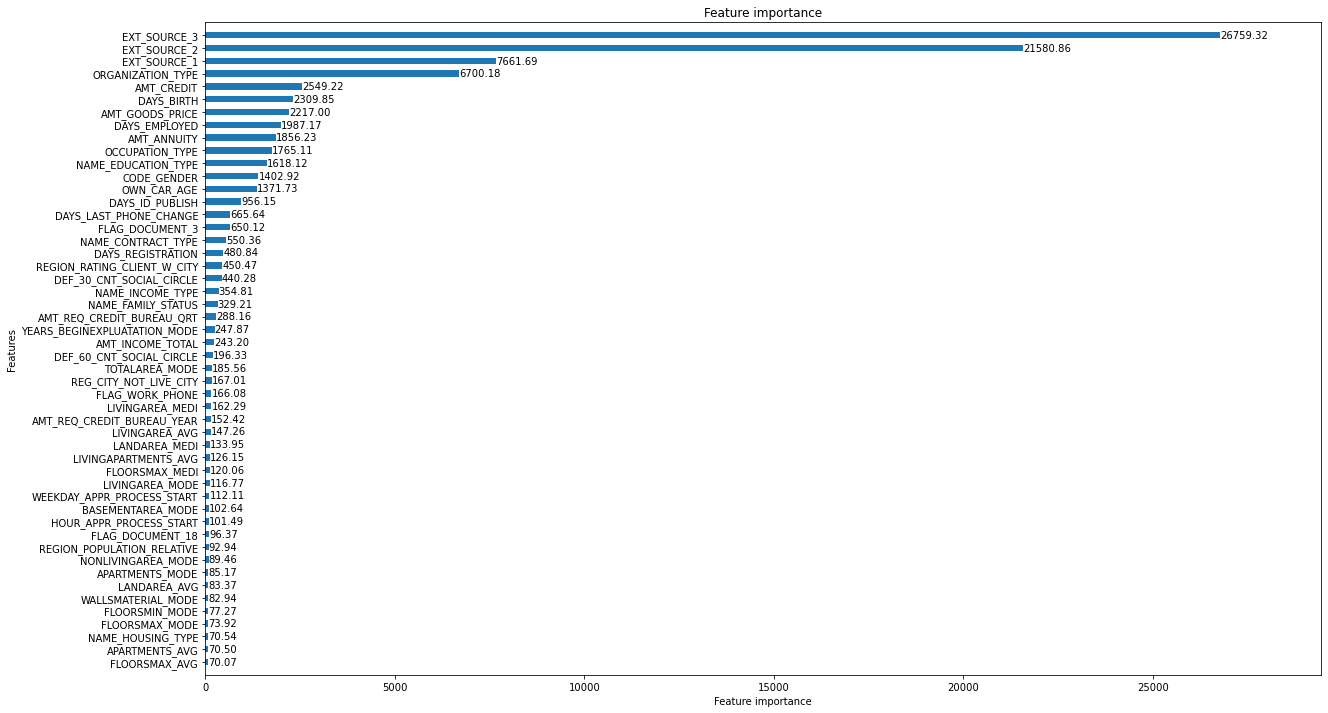

In [30]:
variable_importance_dir
variable_importance_gain_plot = lgb.plot_importance(model, max_num_features=50, importance_type='gain', precision=2, grid=False, figsize=(20, 12), height=0.5)
variable_importance_gain_plot.get_figure().savefig(os.path.join(variable_importance_dir, 'variable_importance_gain.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")


'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/variable_importance'

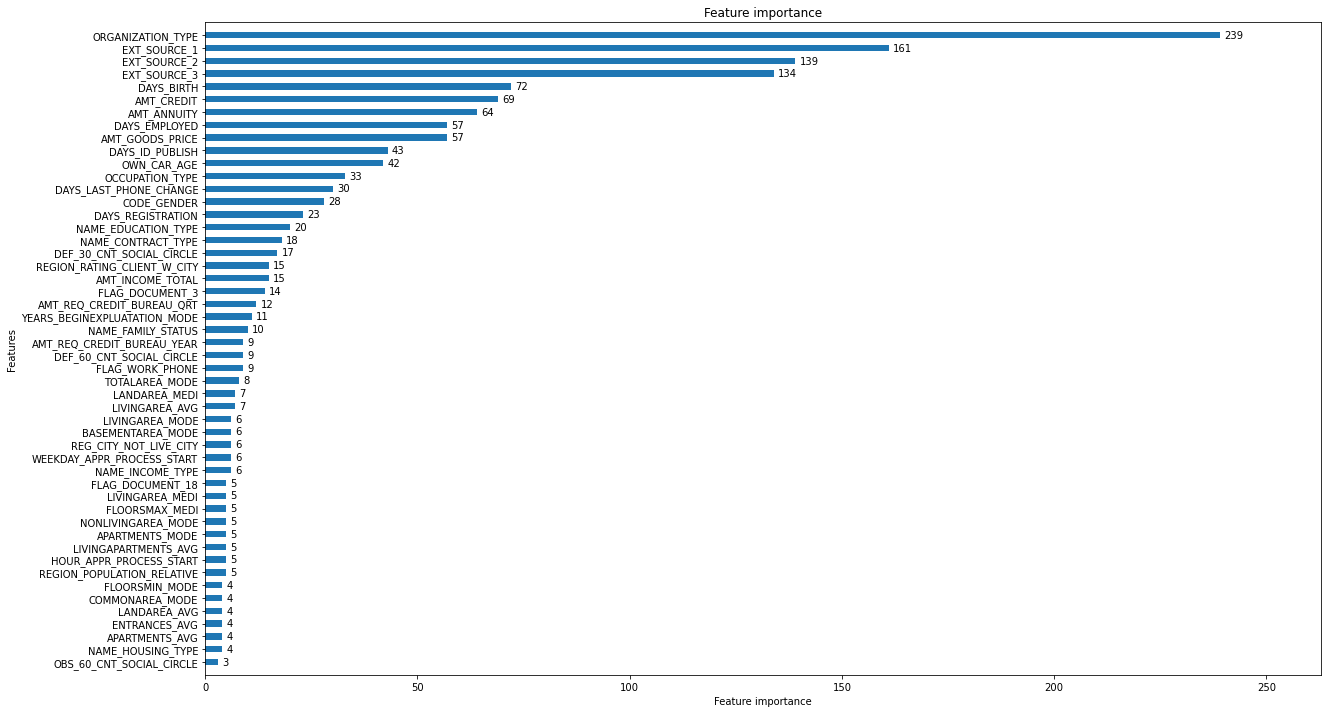

In [31]:
variable_importance_dir
variable_importance_split_plot = lgb.plot_importance(model, max_num_features=50, importance_type='split', precision=2, grid=False, figsize=(20, 12), height=0.5)
variable_importance_split_plot.get_figure().savefig(os.path.join(variable_importance_dir, 'variable_importance_split.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")


### PVO


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


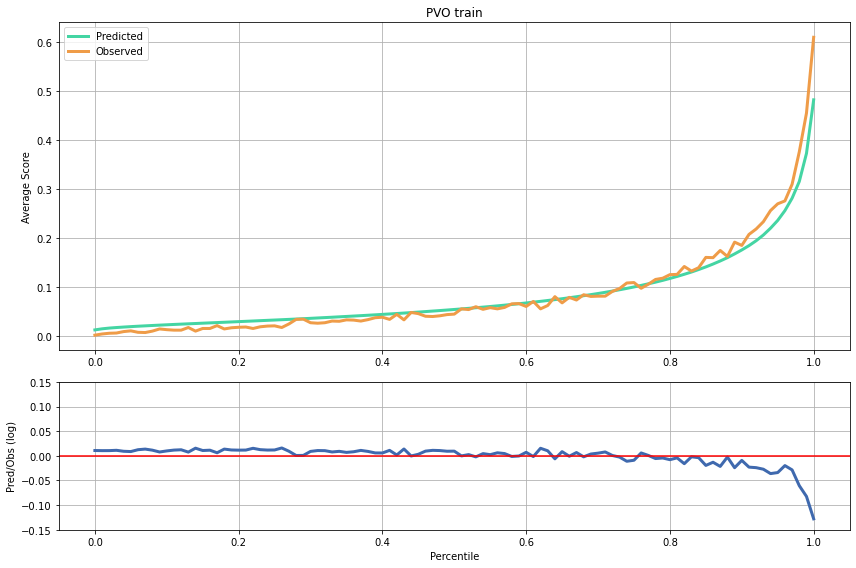

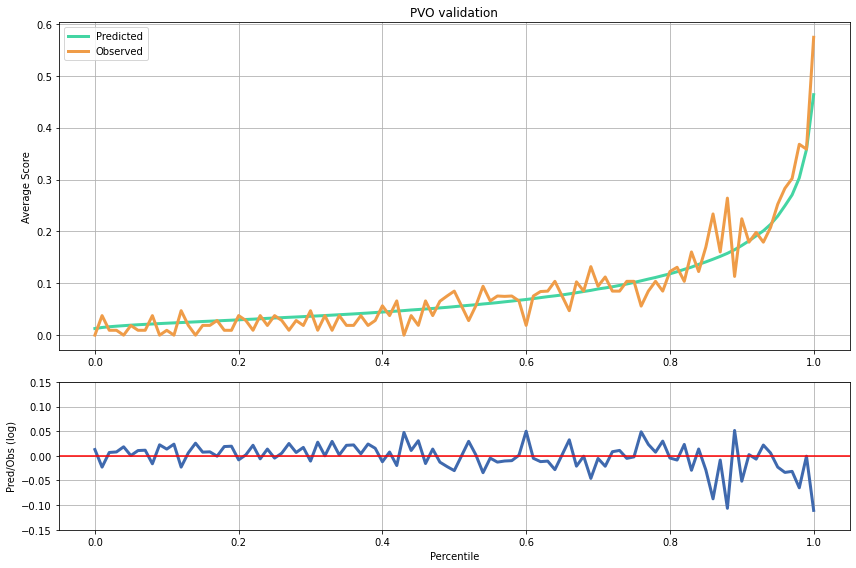

In [32]:
# We will use 100 quantiles, i.e. percentiles, for our PvOs
train['quantile'] = round(train['prediction'].rank(pct=True), 2)
validation['quantile'] = round(validation['prediction'].rank(pct=True), 2)

train_pvo = (
    train
        .loc[:, ['prediction', response, 'quantile']]
        .groupby(
            'quantile',
            as_index=False
        )
        .mean()
)

validation_pvo = (
    validation
        .loc[:, ['prediction', response, 'quantile']]
        .groupby(
            'quantile',
            as_index=False
        )
        .mean()
)

train_pvo_fig = plot_pvo(
    data=train_pvo,
    title='PVO train',
    actual_col=response,
    pred_col='prediction',
    percentile_col='quantile'
)
train_pvo_fig.savefig(os.path.join(pvo_dir, 'train_PvO.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")

validation_pvo_fig = plot_pvo(
    data=validation_pvo,
    title='PVO validation',
    actual_col=response,
    pred_col='prediction',
    percentile_col='quantile'
)
validation_pvo_fig.savefig(os.path.join(pvo_dir, 'validation_PvO.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")


### Oneways

### PDP

### SHAP

In [33]:
explainer = shap.TreeExplainer(model)

# below shap values are a list of ndarray of length 2. 
# index 0 = shap values for TARGET=0
# index 1 = shap values for TARGET=1
# only difference between values in index 0 and index 1 is the sign of the shap value. I.e. (impact on TARGET=0) = -1 * (impact on TARGET=1)
shap_values = explainer.shap_values(validation[features]) 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Visualize a single prediction

In [34]:
row = 5 # which row/observation would you like a SHAP explanation for?
shap.force_plot(explainer.expected_value[1], shap_values[1][row,:], validation[features].iloc[row,:])

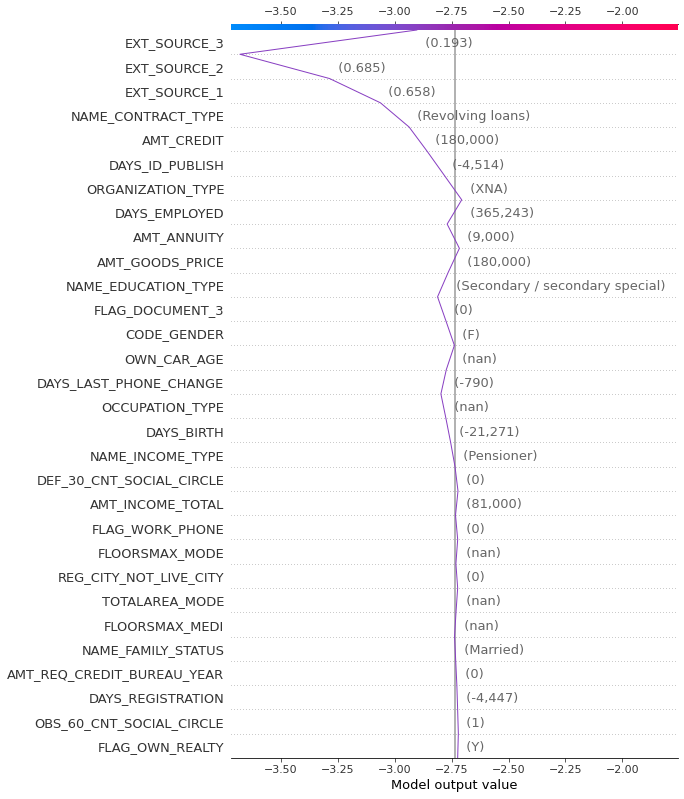

In [36]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][row,:], validation[features].iloc[row,:], feature_display_range=slice(None, -31, -1))

#### SHAP Summary Plot

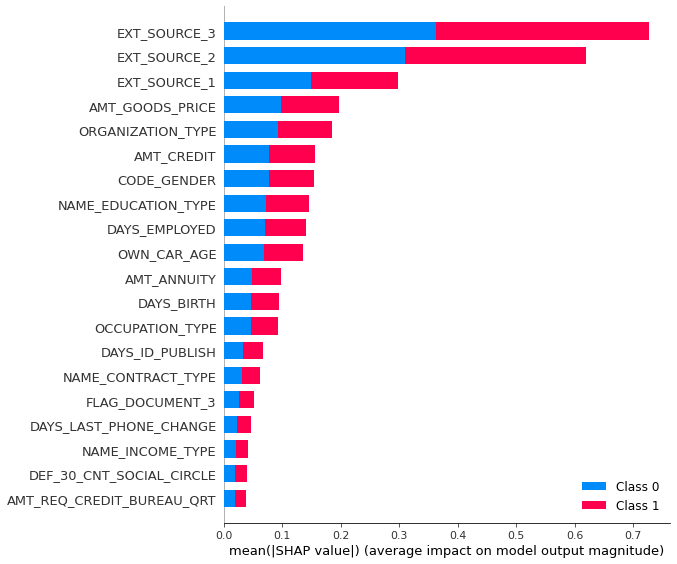

In [37]:
shap.summary_plot(shap_values, validation[features])

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples

not enough data in bin #3 for feature NAME_INCOME_TYPE, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #4 for feature NAME_INCOME_TYPE, so it'll be ignored. Try increasing the number of records to plot.


TypeError: '<' not supported between instances of 'str' and 'float'

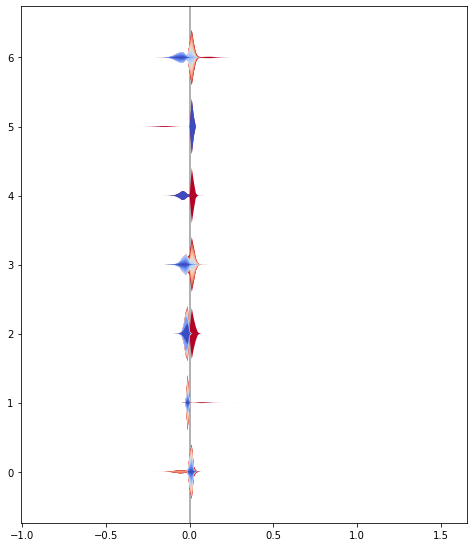

In [38]:
shap.summary_plot(shap_values[1], validation[features], plot_type='layered_violin')

#### SHAP dependence plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

In [37]:
for name in features:
    shap.dependence_plot(name, shap_values[1], validation[features], display_features=validation[features])

TypeError: '<' not supported between instances of 'str' and 'float'

#### SHAP interaction values

In [38]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker

validation_for_shap_interactions = validation[features]

for _, categorical_features in model_categorical_feature_levels.items():
    for cat_feature, numerical_encodings in categorical_features.items():
        validation_for_shap_interactions[cat_feature] = validation_for_shap_interactions[cat_feature].replace({v: k for k, v in numerical_encodings.items()})

validation_for_shap_interactions
        
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(validation_for_shap_interactions[features].iloc[:2000, :])
shap_interaction_values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,1,1,1,0,"283,500.0000","180,000.0000","9,000.0000","180,000.0000",6.0000,1,4,1,1,0.0053,-20259,-9894,"-9,025.0000",-3639,10.0000,1,1,0,1,0,0,8.0000,2.0000,2,2,6,15,0,0,0,0,0,0,13,0.3376,0.4454,0.5989,0.0928,0.1078,0.9796,nan,nan,0.0000,0.2069,0.1667,nan,0.0970,nan,0.0906,nan,0.0000,0.0945,0.1118,0.9796,nan,nan,0.0000,0.2069,0.1667,nan,0.0993,nan,0.0944,nan,0.0000,0.0937,0.1078,0.9796,nan,nan,0.0000,0.2069,0.1667,nan,0.0987,nan,0.0923,nan,0.0000,nan,0.0000,0.0780,4.0000,0.0000,4.0000,0.0000,4.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000
9,0,0,0,1,0,"427,500.0000","760,225.5000","32,337.0000","679,500.0000",6.0000,1,1,1,1,0.0226,-11732,-874,"-4,017.0000",-3023,nan,1,1,1,1,1,0,3.0000,2.0000,2,2,5,8,0,0,0,0,0,0,2,0.2911,0.5724,0.4490,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,-478.0000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
11,0,0,1,1,3,"157,500.0000","728,460.0000","44,694.0000","675,000.0000",6.0000,1,1,1,1,0.0725,-12203,-827,-169.0000,-4879,9.0000,1,1,0,1,0,1,nan,5.0000,1,1,0,13,0,0,0,0,0,0,5,0.8214,0.6858,0.6397,0.3959,0.0849,0.9995,nan,nan,0.4800,0.2069,0.6667,nan,1.0000,nan,0.3888,nan,0.0744,0.4034,0.0881,0.9995,nan,nan,0.4834,0.2069,0.6667,nan,1.0000,nan,0.4051,nan,0.0787,0.3997,0.0849,0.9995,nan,nan,0.4800,0.2069,0.6667,nan,1.0000,nan,0.3958,nan,0.0759,nan,0.0000,0.3220,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-823.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
23,0,1,0,1,0,"180,000.0000","1,800,000.0000","54,706.5000","1,800,000.0000",6.0000,7,1,3,1,0.0264,-9473,-1509,"

AttributeError: 'TreeEnsemble' object has no attribute 'values'

In [39]:
shap.summary_plot(shap_interaction_values, validation_for_shap_interactions.iloc[:2000,:], )

NameError: name 'shap_interaction_values' is not defined

### Other diagnostics

#### ROC Curve

ROC charts are typically used in classification type problems, where you are trying to assess a model's ability to class the data into different groups.

The chart plots the Sensitivity of the model against the False Positive Rate (or 1 - Specificity). These values are built based off of a confusion matrix, and are defined as being:

1 - Specificity = False Positive Rate = FP / (FP + TN)

Sensitivity = True Positive Rate = TP / (TP + FN)

In order to build a ROC chart, the points are constructed using many different cut-off thresholds to split the predicted values into Yes / No.

When the ROC moves towards the upper left, this indicates a better fitting model, with anything sitting below the diagonal line indicating the model is worse than random.

#### Gains curve

Gains curves are used to determine how good a model is at ranking data. They represent the percentage of the response that is captured in the highest ranked portion of the data (according to the model). A useless model will provide a random prediction which means that in each 10% of the data ranked by the model we will get 10% of the responses. The perfect model is determined based on ranking the data by the actual response levels (a perfect ranking). 

The main use of a gains curve is to compare competing models. When comparing multiple models, the model with a gains curve closest to the perfect curve indicates the best model performer.

'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/gains_curve'

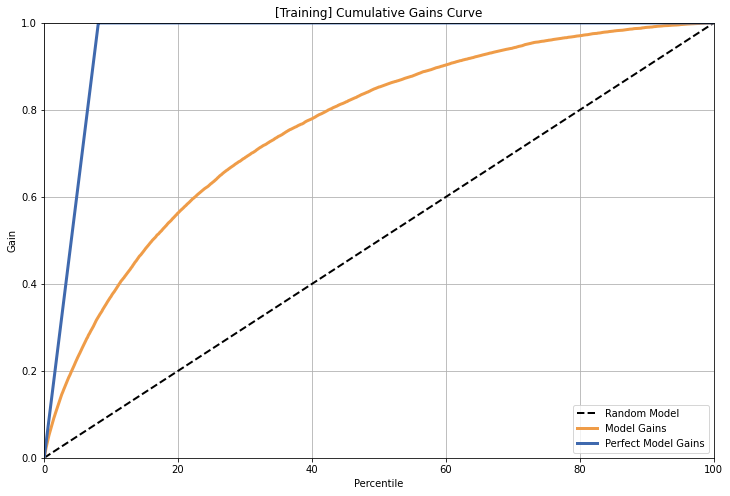

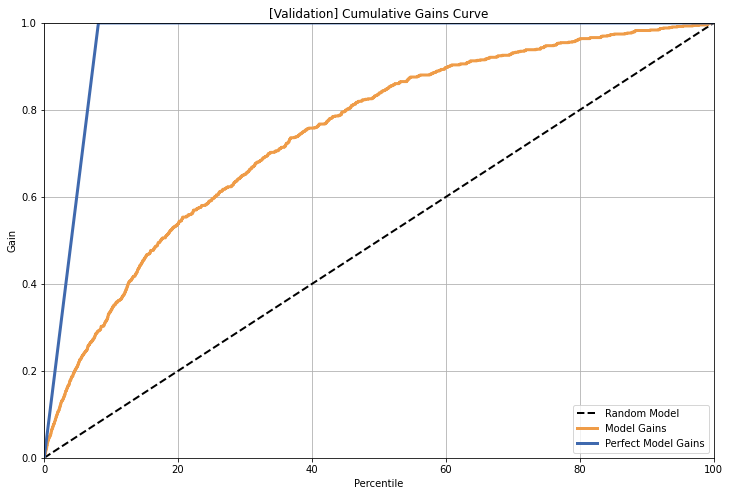

In [39]:
train_gain_curve = plot_cumulative_gain_single(train[response], train['prediction'], title='[Training] Cumulative Gains Curve', figsize=(12, 8))
validation_gain_curve = plot_cumulative_gain_single(validation[response], validation['prediction'], title='[Validation] Cumulative Gains Curve', figsize=(12, 8))

gains_curve_dir
train_gain_curve.savefig(os.path.join(gains_curve_dir, 'train_gains_curve.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")
validation_gain_curve.savefig(os.path.join(gains_curve_dir, 'validation_gains_curve.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")

'/home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/gains_curve'

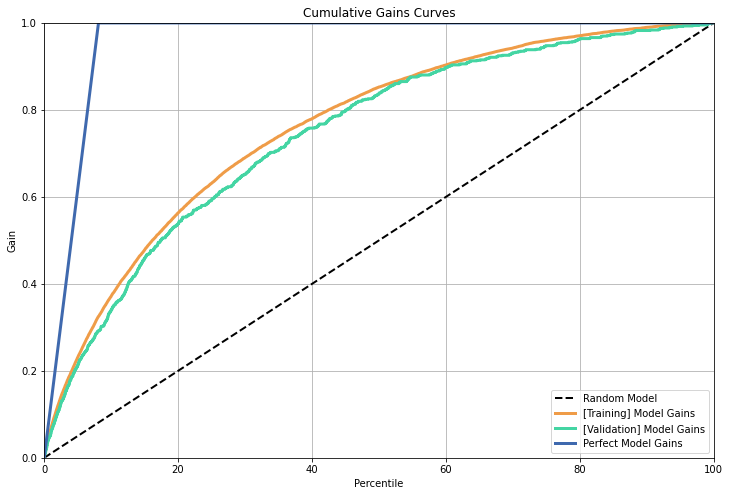

In [40]:
gains_data, combined_gains_plot = plot_cumulative_gain_multiple(
    {
        'Training': {
            response: train[response]
            , 'prediction': train['prediction']
        }
        , 'Validation': {
            response: validation[response]
            , 'prediction': validation['prediction']
        }
    }
    , figsize=(12, 8)
)

gains_curve_dir
gains_data.to_csv(path_or_buf=train_validation_gains_curve_csv_filename, header=True, index=False)
combined_gains_plot.savefig(os.path.join(gains_curve_dir, 'combined_gains_curve.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")

#### Gini

The gini metric is a measure of how accurately a model sorts the observed values. It is dependent only on the order of the predictions, rather than their magnitude. The value is between -1 and 1, with a random model giving a value of 0. Negative values are not common, and indicate that the model is sorting the data backwards.

We usually work with the normalised gini, since even a perfect model (where predicted = observed) does not have a gini value of 1 (the perfect model's gini value depends on the distribution of observed values).  The normalised gini is calculated by dividing the evaluated model's gini by the perfect model's gini.

In [41]:
train_gini = gini_normalised(train[['TARGET', 'prediction']], col_obs='TARGET', col_pred='prediction')
validation_gini = gini_normalised(validation[['TARGET', 'prediction']], col_obs='TARGET', col_pred='prediction')

gini_scores = {
    'train': train_gini
    , 'validation': validation_gini
}

gini_scores
save_json(gini_scores, gini_json_filename)

{'train': 0.5693165912347936, 'validation': 0.5318159833985747}

Directory already exists: /home/nikankarla/modelling_club_team9/mdawkins/05_modelling/models/20210118_190012/diagnostics/gini


#### Lift

Lift charts show how well a model is at splitting/separating the high and low observed responses. They are particularly useful when you are trying to define a segment using the model, and need to consider the trade-off between segment size and model uplift.

The chart shows cumulative lift. Cumulative lift is created by taking the observed average for the top x percentiles and dividing by the overall observed average. For this reason it will always converge to 1 at the tail.

They can be interpreted as showing the increase in response rate from the model compared to taking a simple random sample.

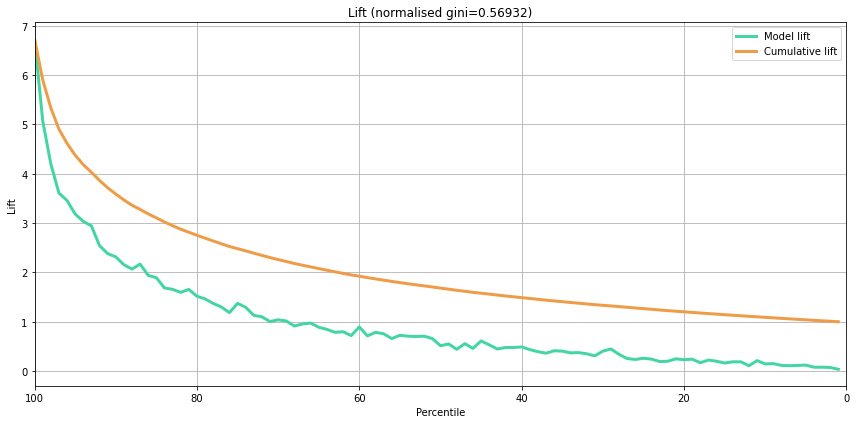

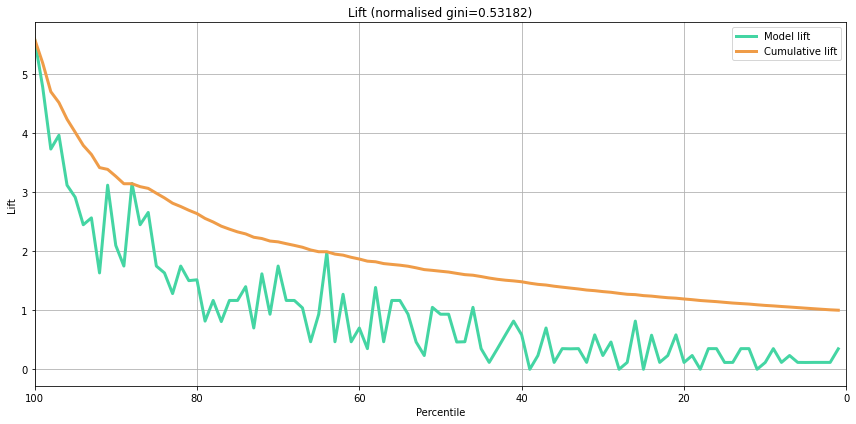

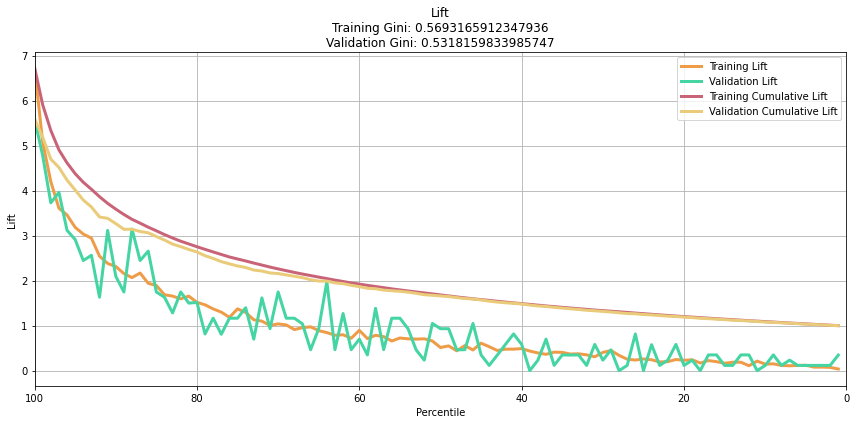

In [42]:
train_lift_plot, train_lift_data, train_cum_lift_data = plot_lift(train[['TARGET', 'prediction']], col_obs='TARGET', col_pred='prediction', gini=True, return_data=True)
validation_lift_plot, validation_lift_data, validation_cum_lift_data = plot_lift(validation[['TARGET', 'prediction']], col_obs='TARGET', col_pred='prediction', gini=True, return_data=True)

train_validation_lift_data = pd.DataFrame(np.array([np.arange(100, 0, -1), train_lift_data, validation_lift_data, train_cum_lift_data, validation_cum_lift_data]).T, columns=['Percentile', 'Train Lift', 'Validation Lift', 'Train Cumulative Lift', 'Validation Cumulative Lift'])
# save csv
train_validation_lift_data.to_csv(path_or_buf=train_validation_lift_csv_filename, header=True, index=False)

# save individual lift curves
train_lift_plot.savefig(os.path.join(lift_dir, 'train_lift.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")
validation_lift_plot.savefig(os.path.join(lift_dir, 'validation_lift.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")

# save combined lift curve
(
    plot_combined_lift(train_validation_lift_data, train_gini=train_gini, validation_gini=validation_gini)
    .savefig(os.path.join(lift_dir, 'combined_lift.png'), facecolor='white', edgecolor='white', transparent=False, bbox_inches = "tight")
)

#### Treeviz

#### Split value histogram

<AxesSubplot:title={'center':'Split value histogram for feature with name AMT_ANNUITY'}, xlabel='Feature split value', ylabel='Count'>

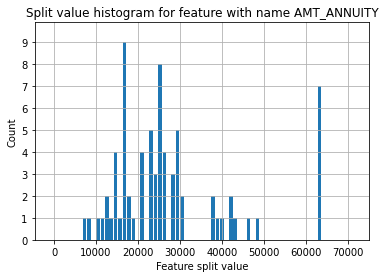

In [42]:
# Do for top 50 features (by gain importance?), and only if it's not a categorical feature!!!!!!!!
lgb.plot_split_value_histogram(model, feature='AMT_ANNUITY')

#### Tree digraph

In [43]:
lgb.create_tree_digraph(model, tree_index=0, show_info='split_gain', orientation='vertical')

ImportError: You must install graphviz to plot tree.

# TODO

In [54]:
# [x] Normalize feature importance
# [x] Add gains curves
# [x] Add model lift to lift chart
# [ ] Write up ROC Curve code
# [ ] Write up oneway code
# [ ] Write up PDP code
# [ ] Fix shap plot for full list of features
# [ ] Write up treeviz code
# [ ] k-fold CV instead of train/test split?